# Flutter

In [76]:
import numpy as np
import control as c
import control.matlab as ml
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad

## Inputs

In [78]:
massAC = 1200
V = 77
rhoair = 0.962870
b = 11.4
MAC = 0.5
massperlength = 800 / 11 # kg/m
cog = 0.5 # chords
EI = 0.00014458520894992735 * 71e9 # Nm^2
GJ = 5e6 # Nm^2
ac = 0.25 # chords
Cla = 2 * np.pi
z = b / 4
wingboxb, wingboxh = 0.6, 0.3
S1 = 5.5
u = 17 # gust velocity [m/s]

$T = \frac{G J}{L} \theta$

$k_h = \frac{C_1 \cdot E I}{L^3} \qquad k_\alpha = \frac{G J}{L}$

Radius of gyration: $\rho = \sqrt{\frac{I}{m}} = \sqrt{\frac{\text{base} \times \text{height}}{6}}$

In [79]:
class Flutter:
    def __init__(s, **kwargs):
        s.__dict__.update(kwargs)
        s.ac *= s.MAC
        s.q = 0.5 * s.rhoair * s.V ** 2
        s.cg = s.cog * s.MAC
        s.C1 = 3 # Fixed support
        s.M = s.massperlength * (s.b/2 - z)
        s.S = s.S1 / 2 # Half wing area
        s.Iz = (s.M / 6) * s.wingboxb * s.wingboxh # https://www.piping-designer.com/index.php/mathematics/geometry/plane-geometry/2342-thin-wall-rectangle
        s.sys = None
        
    def Divergence ( s, z ):
        ka, kh = 2 * s.GJ / z, s.C1 * s.EI / (z / 2) ** 3
        Dh = 0.02 * 2 * np.sqrt(kh * s.M) # https://www.sciencedirect.com/science/article/pii/S1877705816302284
        Da = 0.02 * 2 * np.sqrt(s.Iz * ka)

        A3 = (1 / s.M) * np.array([-kh, s.Cla * s.q * s.S, -Dh, 0])
        A4 = (1 / s.Iz) * np.array([0, -ka + s.Cla * s.q * s.S * (s.cg - s.ac) * s.MAC, 0, -Da])

        A = np.array([[0, 0, 1, 0],
                      [0, 0, 0, 1], A3, A4])
        B = np.concatenate([np.zeros((2, 2)), [[1 / s.M, 0], [0, 1 / s.Iz]]])
        C = np.concatenate([np.identity(4), A[-2:, :], [[0, s.Cla * s.q * s.S, 0, 0]]])
        D = np.concatenate([np.zeros((4, 2)), [[1 / s.M, 0], [0, 1 / s.Iz]], np.zeros((1, 2))])

        s.sys = ml.ss(A, B, C, D)
        return s.sys
    
    def gustResponse(s, u):
        steps = int(1e4)
        force = np.concatenate([np.array([[(s.q / s.V) * s.Cla * s.S * u, (s.q / s.V) * s.Cla * s.S * u * (s.cg-s.ac)]]).T] + \
                                   [[[0]*(steps-1), [0]*(steps-1)]], axis=1)
        T = np.linspace(0, 10, steps)
        T, y = c.forced_response(s.sys, T, U=force)
        return T, y
    
    def plotResponse(s, u):
        T, y = s.gustResponse(u)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 2)
        sns.lineplot(x=T, y=y[1, :] * 180 / np.pi)
        plt.xlabel('Time [s]')
        plt.ylabel('Angular displacement [degrees]')
        plt.subplot(1, 2, 1)
        sns.lineplot(x=T, y=y[0, :]*1e3)
        plt.xlabel('Time [s]')
        plt.ylabel('Vertical displacement [mm]')
        plt.savefig('divergence.jpg')
        plt.show()

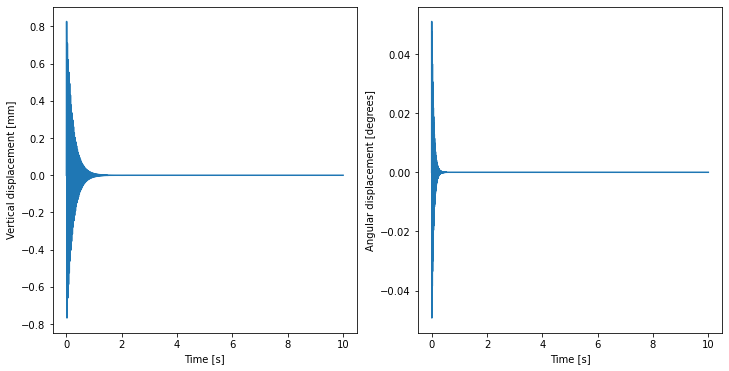

In [80]:
inp = dict(massAC=massAC, rhoair=rhoair, b=b,
               MAC=MAC, massperlength=massperlength, cog=cog, EI=EI, GJ=GJ, ac=ac,
               Cla=Cla, wingboxb=wingboxb, wingboxh=wingboxh, S1=S1, distanceT=distanceT)
flut = Flutter(V=510, **inp)
flut.Divergence(flut.b/4)
flut.plotResponse(u)

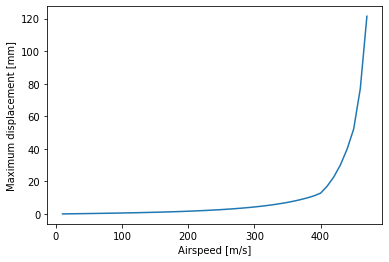

In [75]:
Vs = list(range(10, 480, 10))
ys = []
for V in Vs:
    flut = Flutter(V=V, **inp)
    flut.Divergence(flut.b/4)
    T, y = flut.gustResponse(u)
    ys.append(y[0, :].max()*1000)

sns.lineplot(x=Vs, y=ys)
plt.xlabel('Airspeed [m/s]')
plt.ylabel('Maximum displacement [mm]')
plt.savefig('divespeed.jpg')

In [9]:
np.linalg.eigh(sys.A)

(array([-22079.63413583,  -3501.63806797,   3500.5965906 ,  22073.6252777 ]),
 matrix([[-0.00123958,  0.70705311,  0.70715827,  0.00124032],
         [ 0.70705758,  0.00123805,  0.00124185, -0.70715381],
         [-0.00781689,  0.70711614, -0.70701097, -0.00781944],
         [ 0.70711169,  0.00781846, -0.00781787,  0.70701542]]))

## Whirl Flutter

In [ ]:
V = 10
R = np.sqrt(0.46 / np.pi)
r = R / 4
t = 0.1 * r
frac = 0.6
Omega = 4000*2*np.pi/60
chord = 0.5 # propeller
a =  4 # Distance to connection (in radii)
Nb = 5 # Number of blades
rhoair = 0.962870
clalpha = 2 * np.pi # lift curve prop

In [ ]:
from Material import Material
steel = Material.load(file='../data/materials.csv', material='AISI 4140', Condition='Annealed')
steel.E
t, r, a*r

In [ ]:
Mprop, Msupp = 502 * np.array([frac, 1-frac])
Ix, In = 0.5 * Mprop * (R) ** 2 + (a * R) ** 2 * Msupp, 0.5 * Mprop * (R) ** 2 + (a * R) ** 2 * Mprop + 0.25 * Mprop * r ** 2 + Mprop * (a * R) ** 2 / 3
Ixx = np.pi / 4 * (r ** 4 - (r - t) ** 4)
E = 204774372000
Kth = Kpsi = 3 * E * Ixx / (a * R) ** 3

print(f"{Kth = }, {Ixx = }")
Dth, Dpsi = 0.02 * np.sqrt(Kth * In), 0.02 * np.sqrt(Kpsi * In)
print(f"{Dth = }, {In = }")

mu = V / (Omega * R)
A1 = (chord / R) * quad(lambda eta: mu * mu / np.sqrt(mu*mu + eta*eta), 0, 1)[0]
A1p = mu * A1
A2p = (chord / R) * quad(lambda eta: mu * mu * eta*eta / np.sqrt(mu*mu + eta*eta), 0, 1)[0]
A3 = (chord / R) * quad(lambda eta: eta*eta / np.sqrt(mu*mu + eta*eta), 0, 1)[0]
Ka = 0.5 * rhoair * clalpha * R ** 4 * Omega * Omega
A34 = Nb * 0.5 * Ka * R * np.array([[a*A1p, -A2p, -(A3+a*a*A1)/Omega, 0],
                                   [A2p, a*A1p, 0, -(A3 + a*a*A1)/Omega]])

M = np.array([[In, 0], [0, In]])
K = np.array([[Kth, 0], [0, Kpsi]])
D = np.array([[Dth, -Ix * Omega], [Ix * Omega, Dpsi]])

J = np.concatenate([np.concatenate([np.zeros((2, 2)), np.identity(2)], axis=1),
                   np.concatenate([-np.linalg.inv(M) @ K, -np.linalg.inv(M) @ D], axis=1)])

A = np.concatenate([J[:2, :], A34 + J[2:, :]])
B = np.concatenate([np.zeros((2, 2)), -np.linalg.inv(M)])
C = np.concatenate([np.identity(4), A[-2:]])
D = np.concatenate([np.zeros((2, 2)), B])
sys = ml.ss(A, B, C, D)
t, y = c.forced_response(sys, T=np.linspace(0, 5, 1000), U=0, X0=np.array([[np.pi/180/2,  np.pi/180/2] + [0]*2]).T)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
sns.lineplot(x=t, y=y[1, :] * 180 / np.pi)
plt.xlabel('Time [s]')
plt.ylabel('Yaw displacement [degrees]')
plt.subplot(1, 2, 1)
sns.lineplot(x=t, y=y[0, :] * 180 / np.pi)
plt.xlabel('Time [s]')
plt.ylabel('Pitch displacement [degrees]')
plt.savefig('whirl.jpg')

In [ ]:
vals, vex = np.linalg.eigh(sys.A)
D = np.array([[Dth, -Ix * Omega], [Ix * Omega, Dpsi]])
np.linalg.eigh(D)[0]